## After wrangling and exploring the data in previous notebooks, this notebook will explore feature engineering and then forecasting the total electricity load using regression, time series forecasting, and ensemble methods.

In [1]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#import preprocessing/modeling/error metric packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor

In [2]:
combined_avg = pd.read_csv('../raw_data/combined_avg.csv', index_col='time', parse_dates=True)

In [3]:
combined_avg.head(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,total load actual,price day ahead,price actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,25385.0,50.1,65.41,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,24382.0,48.1,64.92,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0


In [4]:
combined_avg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

In [5]:
#function to make train-test split for time-indexed data
def ts_train_test(data, target_col_name = 'total load actual', test_size=0.15, stdzd=False, cols_to_scale=None):
    df = data.copy()
    test_index = int(len(df)*(1-test_size)) #get index where test set begins
        
    X_train = df.drop([target_col_name], axis = 1).iloc[:test_index]
    y_train = df[target_col_name].iloc[:test_index]
    X_test = df.drop([target_col_name], axis = 1).iloc[test_index:]
    y_test = df[target_col_name].iloc[test_index:]
    
    # StandardScaler fit seperately on training and test sets
    if stdzd == True:
        scaler = StandardScaler()
        X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
        X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
    
    return X_train, X_test, y_train, y_test        

In [6]:
#Let's engineer some categorical features for use in a regression model like weekend/weekday, winter/summer/spring-fall
df_features = combined_avg.iloc[:,16:].drop(['price day ahead', 'price actual','total load forecast'], axis=1)
features_min = df_features.copy()
df_features.head()

,total load actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
time,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,21286.0,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,20264.0,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0


In [7]:
#function to calculate basic season label based on month
def season_determination(month):
    if month in [6,7,8,9]: #June-Sept = summer (highest need for cooling in Spain)
        return "summer"
    elif month in [1,2,12]: #Dec, Jan, Feb = winter (highest need for heating)
        return "winter"
    else:
        return "spring/fall" #all other months are spring or fall (similar lower needs for heating/cooling)

In [8]:
day_of_week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
df_features['hour'] = df_features.index.hour
df_features['weekday'] = df_features.index.weekday.map(day_of_week)
df_features['month'] = df_features.index.month #have to create month column because cannot apply() on datetimeindex
df_features['season'] = df_features.month.apply(season_determination)
df_features['nonwork-work_day'] = np.where(df_features.index.weekday > 5, 0, 1)
display(df_features.shape, df_features.head());

(35064, 13)

,total load actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,hour,weekday,month,season,nonwork-work_day
time,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0,23,Wednesday,12,winter,1
2015-01-01 00:00:00+00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0,0,Thursday,1,winter,1
2015-01-01 01:00:00+00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0,1,Thursday,1,winter,1
2015-01-01 02:00:00+00:00,21286.0,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0,2,Thursday,1,winter,1
2015-01-01 03:00:00+00:00,20264.0,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0,3,Thursday,1,winter,1


In [9]:
df_features.drop("month", axis=1, inplace=True)

Now that I've used the weekday and month to create the type_of_day and season columns, 
I need to drop the month column because the test set may not contain all months. Now time to one-hot encode the new categorical variables.

In [10]:
#let's split data and then encode the new catergorical variables
X_train, X_test, y_train, y_test = ts_train_test(data = df_features, stdzd=True, 
                                                 cols_to_scale=['temp','pressure','humidity',
                                                                'wind_speed','rain_1h','snow_3h','clouds_all'])
cat_cols = ['hour','weekday','season']
X_train_cat = X_train[['hour','weekday','season']]
X_test_cat = X_test[['hour','weekday','season']]

encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

encoder.fit(X_train_cat)
X_train.drop(columns = cat_cols, inplace=True)
X_train_cat = pd.DataFrame(encoder.transform(X_train_cat), index=X_train.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
X_train = X_train.join(X_train_cat, how ='outer')
#X_train.head()
encoder.fit(X_test_cat)
X_test.drop(columns = cat_cols, inplace=True)
X_test_cat = pd.DataFrame(encoder.transform(X_test_cat), index = X_test.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
X_test = X_test.join(X_test_cat, how ='outer')

display(X_train.head(3), X_test.head(3), X_train.columns)

,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,nonwork-work_day,hour_1,hour_2,...,hour_22,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_summer,season_winter
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,-2.327401,0.038628,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,1,0,0,...,0,1,0,0,0,0,0,1,0,1
2015-01-01 00:00:00+00:00,-2.324453,0.015395,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,1,0,0,...,0,0,0,0,0,1,0,0,0,1
2015-01-01 01:00:00+00:00,-2.381861,0.085093,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,1,1,0,...,0,0,0,0,0,1,0,0,0,1


,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,nonwork-work_day,hour_1,hour_2,...,hour_22,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_summer,season_winter
time,,,,,,,,,,,,,,,,,,,,,
2018-05-26 19:00:00+00:00,0.656574,-0.333094,-0.243123,-0.064045,-0.369491,-0.052006,-0.265015,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2018-05-26 20:00:00+00:00,0.456407,-0.309861,0.341476,-0.349236,-0.369491,-0.052006,-0.589313,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2018-05-26 21:00:00+00:00,0.295386,-0.263396,0.626978,-0.919619,-0.369491,-0.052006,-0.728298,1,0,0,...,0,0,0,1,0,0,0,0,0,0


Index(['temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
       'clouds_all', 'nonwork-work_day', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'season_summer', 'season_winter'],
      dtype='object')

So now X is split into train and test sets, with the first 85% of the data going to training to try to predict approximately the last 7 months out of the four years of data.

# Modeling

First I have written a couple helper functions for calculating error metrics and for creating a TS plot comparing predicted vs actual load for the various forecasting models I will try out.

### Helper functions

In [119]:
#function for calculating and presenting error metrics, and storing in a dict for comparison at the end
error_dict = {} #dict to hold model name and error metrics for various models that are investigated

def error_metrics(y_true, y_pred, model_name = None):
    
    #function will print RMSE, R2, MAE, MAPE. Assumes y_pred is np array
    
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = (np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

    print('\nError metrics for model: {}'.format(model_name))
    print("RMSE: %.2f" % RMSE)
    print('Variance/R^2: %.2f' % R2)
    print('MAE: %.2f' % MAE)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)
    
    key = ['Model Name','RMSE', 'R2', 'MAE', 'MAPE']
    value = [model_name, RMSE, R2, MAE, MAPE]
    pair = list(zip(key, value))
    '''
    for error in pair:
        error_dict[error[0]]= [error[1]]
    '''
    for error in pair:
        if error[0] in error_dict:
            error_dict[error[0]].append(error[1])
        else:
            error_dict[error[0]]= [error[1]]
            

In [12]:
#function for plotting time series of predicted vs true values
def plot_ts_pred_true(y_pred, y_true, model_name=None):
    fig, ax = plt.subplots(figsize =(15,10))
    ax.plot(y_true.index, y_pred, linestyle='-', linewidth=1, label = 'Model Forecasted Total Load', color = 'blue',alpha = 0.4)
    y_true.plot(linestyle='-', linewidth=1, label = 'Actual Total Load', color = 'red',alpha = 0.4)

    plt.ylabel('Load/Demand (MW)')
    plt.xlabel("Time")
    plt.title("Observed vs model-predicted total load (MWH) using {}".format(model_name))
    plt.legend()
    plt.show()

First I will try out a simple linear regression using the weather and categorical variables:
### Linear Regression

In [13]:
#instantiate and fit linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [120]:
#calculate error metrics for train set
error_metrics(linreg.predict(X_train), y_train, model_name = 'simple linear regression (train)')


Error metrics for model: simple linear regression (train)
RMSE: 2860.94
Variance/R^2: 0.36
MAE: 2202.74
Mean Absolute Percentage Error: 7.64 %


In [121]:
#calculate error metrics for test set
error_metrics(linreg.predict(X_test), y_test, model_name = 'simple linear regression (test)')


Error metrics for model: simple linear regression (test)
RMSE: 2850.02
Variance/R^2: 0.36
MAE: 2174.66
Mean Absolute Percentage Error: 7.55 %


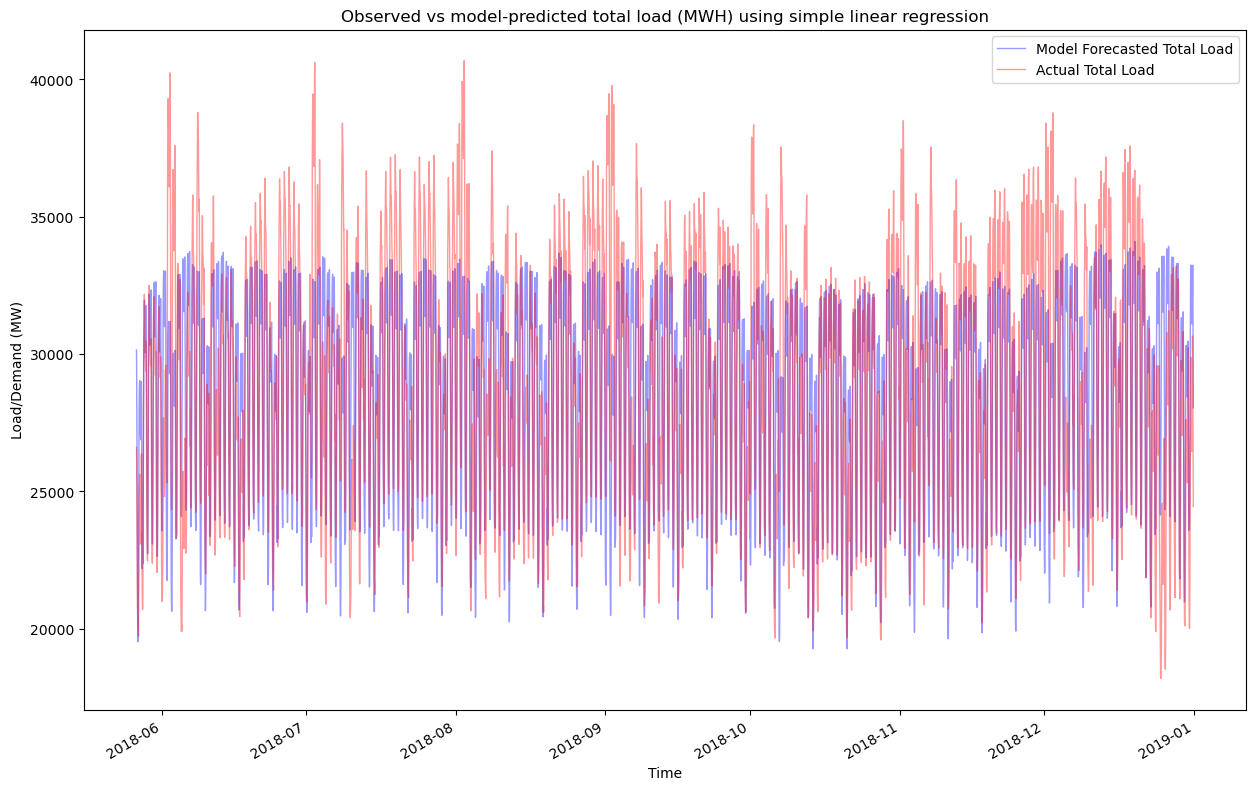

In [16]:
plot_ts_pred_true(y_pred = linreg.predict(X_test), y_true = y_test, model_name = "simple linear regression")

In [17]:
#let's try using a df with reduced feature space, by eliminating some possibly extraneous variables:

X_train_red = X_train.drop(['hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 
       'weekday_Thursday', 'weekday_Tuesday','weekday_Wednesday',], axis=1)
X_test_red = X_test.drop(['hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 
       'weekday_Thursday', 'weekday_Tuesday','weekday_Wednesday',], axis=1)

### Linear regression on reduced feature space

In [68]:
#instantiate and fit linear regression model for reduced feature space train set
linreg_red = LinearRegression()
linreg_red.fit(X_train_red, y_train)

LinearRegression()

In [122]:
#calculate error metrics for linear regr with reduced feature train set
error_metrics(y_train, linreg_red.predict(X_train_red), model_name = 'simple linear regression on reduced features (train)')


Error metrics for model: simple linear regression on reduced features (train)
RMSE: 3977.88
Variance/R^2: 0.24
MAE: 3275.40
Mean Absolute Percentage Error: 11.77 %


We can see that the simple linear regression model using the larger set of features predicts the weekly seasonality fairly well but is often over or underpredicting the max daily load. The model using the reduced feature space performs worse. I will also check out a baseline model that just predicts the same as the value for the same date/time from the previous year:
### Simple Year-over-Year Baseline 

In [118]:
# errors metrics for a baseline forecast (that simply repeats the values from the previous year)
#error_metrics(y_true, y_pred, model_name = None)
error_metrics(y_test, df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'],
              model_name='Baseline forecast (repeat of previous year) (test)')



Error metrics for model: Baseline forecast (repeat of previous year) (test)
RMSE: 3100.81
Variance/R^2: 0.54
MAE: 2249.00
Mean Absolute Percentage Error: nan %


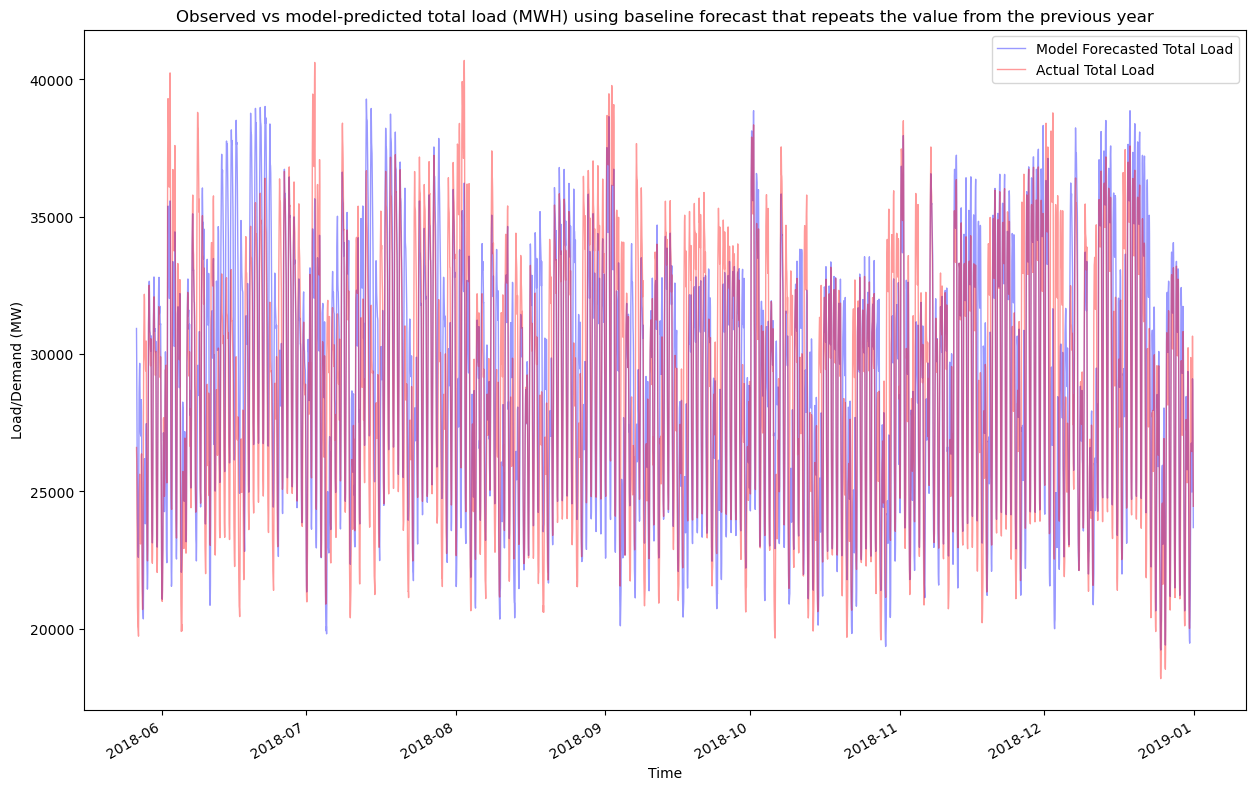

In [21]:
# plot y_pred and y-true for baseline year over year
plot_ts_pred_true(y_pred = df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'], y_true = y_test, 
                  model_name = "baseline forecast that repeats the value from the previous year")

Visually we can can see that the baseline model that just uses the value from the same time from the previous year does a decent job, but misses is off pretty badly sometimes. Which makes sense, because on average things are similar year to year but the peak demand will definitely be much higher or much lower on certain days. Let's try out a couple more regression models before trying some time series forecasting:

### Random Forest

In [71]:
#set up a parameter grid of different values for GridSearchCV of number of trees and max depth
n_est = [int(n) for n in np.logspace(start=1, stop=2.5, num=12)]
max_depth = list(range(1,6))

param_grid = {
        'n_estimators': n_est,
        'max_depth': max_depth
}
param_grid

{'n_estimators': [10, 13, 18, 25, 35, 48, 65, 90, 123, 168, 231, 316],
 'max_depth': [1, 2, 3, 4, 5]}

In [72]:
#create instance of base model
rfreg = RandomForestRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
rf_cv = RandomizedSearchCV(rfreg, param_distributions=param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
rf_cv.fit(X_train_red, y_train)

rf_cv.best_params_


{'n_estimators': 65, 'max_depth': 5}

The R^2 score:

In [73]:
rf_cv.score(X_train_red, y_train)

0.2807054066640785

In [74]:
rf_cv.score(X_test_red, y_test)

0.26070686480809446

In [123]:
#RF error metrics
error_metrics(y_train, rf_cv.predict(X_train_red),  
                  model_name = 'Random Forest Regression on reduced feature space tuned with Random Search CV (train)')


Error metrics for model: Random Forest Regression on reduced feature space tuned with Random Search CV (train)
RMSE: 3876.44
Variance/R^2: 0.28
MAE: 3180.79
Mean Absolute Percentage Error: 11.47 %


Let's also try Random Forest on the full feature space dataset:

In [76]:
#create instance of base model
rfreg = RandomForestRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
rf_cv_full = RandomizedSearchCV(rfreg, param_distributions=param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
rf_cv_full.fit(X_train, y_train)

rf_cv_full.best_params_

{'n_estimators': 13, 'max_depth': 5}

In [77]:
rf_cv_full.score(X_train, y_train)

0.3711857325889102

In [78]:
rf_cv_full.score(X_test, y_test)

0.3781323806515441

In [124]:
error_metrics(y_train, rf_cv_full.predict(X_train), 
                  model_name = 'Random Forest Regression tuned with Random Search CV (train)')


Error metrics for model: Random Forest Regression tuned with Random Search CV (train)
RMSE: 3624.44
Variance/R^2: 0.37
MAE: 2856.58
Mean Absolute Percentage Error: 10.21 %


In [125]:
error_metrics(y_test, rf_cv_full.predict(X_test), 
                  model_name = 'Random Forest Regression tuned with Random Search CV (test)')


Error metrics for model: Random Forest Regression tuned with Random Search CV (test)
RMSE: 3620.30
Variance/R^2: 0.38
MAE: 2846.21
Mean Absolute Percentage Error: 9.91 %


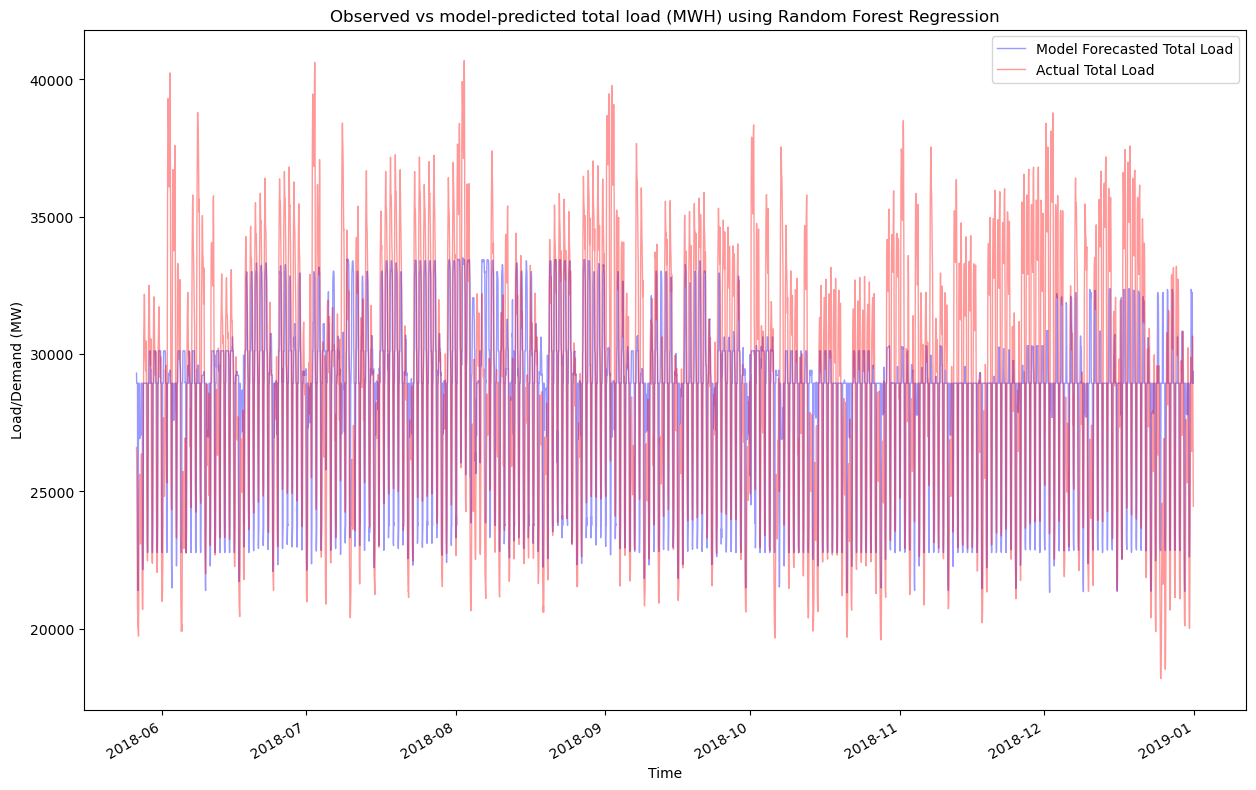

In [32]:
plot_ts_pred_true(y_pred = rf_cv_full.predict(X_test), y_true = y_test, model_name = "Random Forest Regression")

So Random Forest performs slightly worse that linear regression. It seems to consistently underpredict the true values. Let's also try KNeighbors Regression:
###  KNN

In [82]:
#set up a parameter grid for KNeighbors Random CV search:

n_neigh = [int(n) for n in np.logspace(start=0.5, stop=1.8, num=10)]
weights = ['uniform', 'distance']
leaf_size = [int(n) for n in np.logspace(start=0.5, stop=1.9, num=6)]

kn_param_grid = {
        'n_neighbors': n_neigh,
        'weights': weights,
        'leaf_size':leaf_size
}
kn_param_grid

{'n_neighbors': [3, 4, 6, 8, 11, 16, 23, 32, 45, 63],
 'weights': ['uniform', 'distance'],
 'leaf_size': [3, 6, 11, 21, 41, 79]}

In [83]:
#create instance of base model
kn = KNeighborsRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
kn_cv = RandomizedSearchCV(kn, param_distributions = kn_param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
kn_cv.fit(X_train, y_train)

kn_cv.best_params_


{'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 41}

In [50]:
kn_cv.score(X_train, y_train)

0.9999999999999822

In [51]:
kn_cv.score(X_test, y_test)

0.5717077508212619

In [126]:
error_metrics(y_test, kn_cv.predict(X_test), 
                  model_name = 'KNN tuned with Random Search CV (test)')


Error metrics for model: KNN tuned with Random Search CV (test)
RMSE: 3004.46
Variance/R^2: 0.57
MAE: 2187.55
Mean Absolute Percentage Error: 7.44 %


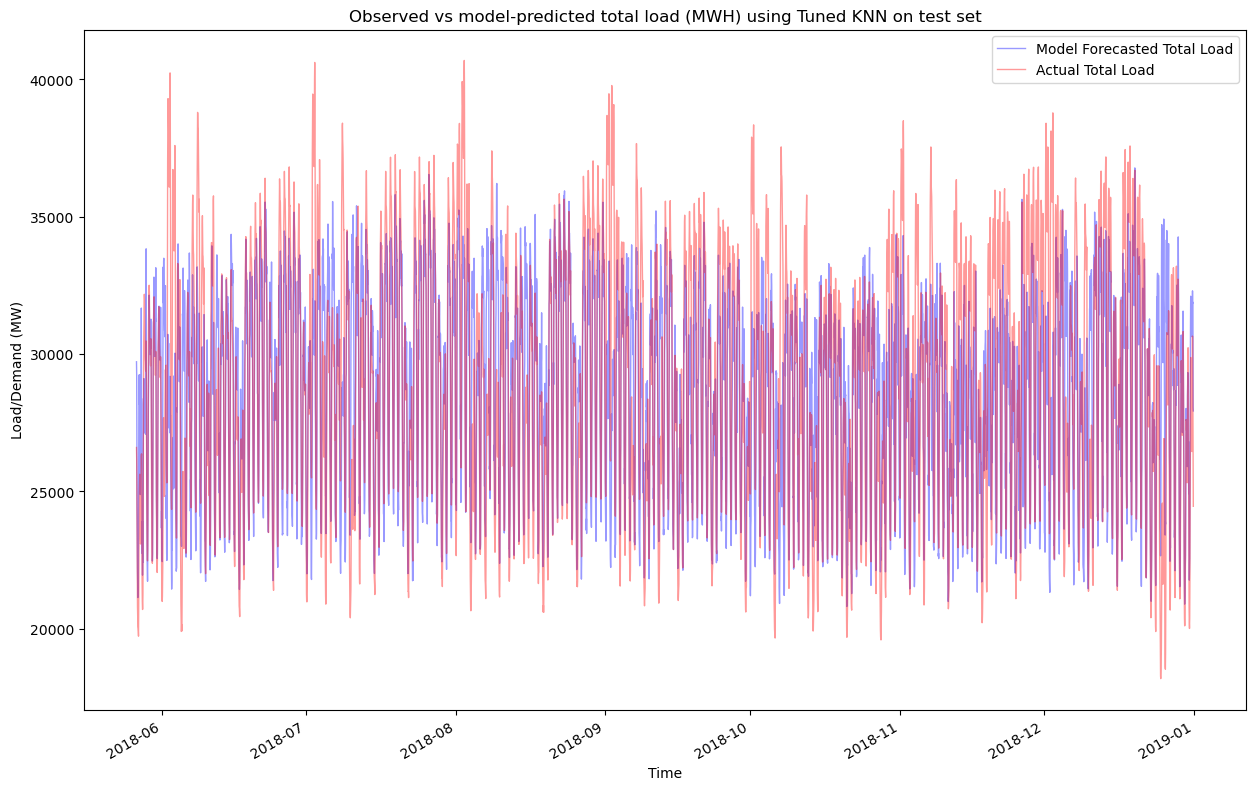

In [53]:
plot_ts_pred_true(y_pred = kn_cv.predict(X_test), y_true = y_test, model_name = "Tuned KNN on test set")

As expected, this model wildly overfits the training data and performs similarly to Random Forest and linear regression on the test data. Now to try some time series forecasting.

# Time Series Forecasting

In [48]:
#%conda install -c conda-forge sktime-all-extras
#import packages
import sktime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [49]:
# a simple time series DF for use in models without the exogenous variables
ts_load = pd.DataFrame(combined_avg["total load actual"], columns=['total load actual'])
ts_load.head()

,total load actual
time,
2014-12-31 23:00:00+00:00,25385.0
2015-01-01 00:00:00+00:00,24382.0
2015-01-01 01:00:00+00:00,22734.0
2015-01-01 02:00:00+00:00,21286.0
2015-01-01 03:00:00+00:00,20264.0


With the univariate TS dataframe, I will use the statsmodels Augmented Dickey-Fuller test to test for stationarity. The null hypothesis is that the series is not stationary (no trend, constant variance over time, constant autocorrelation structure over time) and the alternative hypothesis is that the time series is stationary. If the p-value is less than 0.05, we reject the null hypothesis and conclude the series is stationary. 

In [40]:
#let's use the simple ts df to test for stationarity, as many ts models assume stationarity
adf_result = adfuller(ts_load)
#print test statisitc
print("t-stat", adf_result[0])
# Print p-value
print("p-value", adf_result[1])
# Print number of lags used
print("#lags used", adf_result[2])
# Print critical values
print("critical values", adf_result[4]) 

t-stat -21.420315756960576
p-value 0.0
#lags used 52
critical values {'1%': -3.43053679213716, '5%': -2.8616225575095284, '10%': -2.566813942767471}


With a p-value of zero, we can say that the data are stationary. Even though we know the data have seasonality, perhaps the p-value is so low because there is very little trend. But let's have a look at the decomposition of the trend, seasonality, and residuals. Let's start with the largest seasonal component, the yearly seasonality:

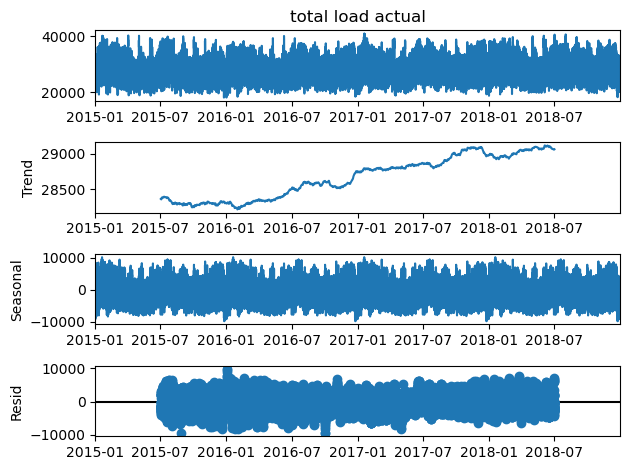

In [41]:
#seasonal decomposition
decomp = sm.tsa.seasonal_decompose(ts_load['total load actual'], period=24*365) #the yearly seasonal component
#the main seasonal component is the shift from winter to spring to summer to fall and back to winter an so on...
# so the period is 24*365

_ = decomp.plot() #plot the seasonal components

So the seasonal decomposition actually does show a trend, but it is so small as to almost be negligible (an increase of about 900 MWH out of about 30000 over 4 years). The seasonal component plot clearly shows the peaks during summer and winter and relative lows in spring and fall.

In [42]:
# Differencing the data once
#decomp_diff1 = sm.tsa.seasonal_decompose(ts_load['total load actual'].diff().dropna(), period=24*365) 
#_ = decomp_diff1.plot()

In [43]:
#Decomposition on the data with 24-hour differencing, 24 being the period of the shortest seasonality in the dataset
#decomp_diff24 = sm.tsa.seasonal_decompose(ts_load['total load actual'].diff(24).dropna(), period=24*365) 
#_ = decomp_diff24.plot()

Now I will use the FourierFeatures class from sktime to create Fourier terms for the multiple seasonalities so that we can use the SARIMAX forecasting model (which only handles a single seasonality). SARIMAX tends to handle short seasonality better than long seasonality, so I can either create Fourier terms for all the seasonalities, or create them only for the yearly/seasonal and weekly seasonalities and let the model handle the daily seasonality.

In [50]:
from sktime.transformations.series.fourier import FourierFeatures
''' example from sktime documentation to help understand implementation of FF
from sktime.datasets import load_airline
y_toy = load_airline()
transformer = FourierFeatures(sp_list=[12], fourier_terms_list=[4])
y_hat = transformer.fit_transform(y_toy)
display(y_toy.head(), y_hat.head())
#https://robjhyndman.com/hyndsight/forecasting-weekly-data/ #shows how to find best value of k
'''
ff_transformer = FourierFeatures(sp_list=[24,24*7,24*365.25], fourier_terms_list=[5,5,5]) #k=5 common value in energy forecasting
load_ff = ff_transformer.fit_transform(ts_load['total load actual'])
display(load_ff.head())

,total load actual,sin_24_1,cos_24_1,sin_24_2,cos_24_2,sin_24_3,cos_24_3,sin_24_4,cos_24_4,sin_24_5,...,sin_8766.0_1,cos_8766.0_1,sin_8766.0_2,cos_8766.0_2,sin_8766.0_3,cos_8766.0_3,sin_8766.0_4,cos_8766.0_4,sin_8766.0_5,cos_8766.0_5
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2015-01-01 00:00:00+00:00,24382.0,0.000017,1.0,0.000033,1.0,0.000050,1.0,0.000067,1.0,-0.000405,...,0.424729,0.905321,0.769031,0.639211,0.967711,0.252063,0.983147,-0.182818,0.812416,-0.583078
2015-01-01 01:00:00+00:00,22734.0,0.000033,1.0,0.000067,1.0,0.000100,1.0,0.000134,1.0,-0.000809,...,0.769031,0.639211,0.983147,-0.182818,0.487848,-0.872929,-0.359473,-0.933155,-0.947404,-0.320041
2015-01-01 02:00:00+00:00,21286.0,0.000050,1.0,0.000100,1.0,-0.000338,1.0,0.000201,1.0,0.000739,...,0.967711,0.252063,0.487848,-0.872929,-0.721774,-0.692129,-0.851713,0.524009,0.292409,0.956293
2015-01-01 03:00:00+00:00,20264.0,0.000067,1.0,0.000134,1.0,0.000201,1.0,0.000268,1.0,-0.001618,...,0.983147,-0.182818,-0.359473,-0.933155,-0.851713,0.524009,0.670889,0.741558,0.606416,-0.795148


Now that I have the seasonalities represented as Fourier terms, I can use the SARIMAX model with autoARIMA for tuning to find the best values of pdq.

In [51]:
#merge the new Fourier df with the features_min df (that excludes engineered features used in regression, 
#and just reverts back to only weather variables)
ff_combined = features_min.drop(['total load actual'], axis=1).merge(load_ff, left_index=True, right_index=True)
ff_combined.head()

,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,total load actual,sin_24_1,cos_24_1,...,sin_8766.0_1,cos_8766.0_1,sin_8766.0_2,cos_8766.0_2,sin_8766.0_3,cos_8766.0_3,sin_8766.0_4,cos_8766.0_4,sin_8766.0_5,cos_8766.0_5
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0,25385.0,0.000000,1.0,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2015-01-01 00:00:00+00:00,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0,24382.0,0.000017,1.0,...,0.424729,0.905321,0.769031,0.639211,0.967711,0.252063,0.983147,-0.182818,0.812416,-0.583078
2015-01-01 01:00:00+00:00,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0,22734.0,0.000033,1.0,...,0.769031,0.639211,0.983147,-0.182818,0.487848,-0.872929,-0.359473,-0.933155,-0.947404,-0.320041
2015-01-01 02:00:00+00:00,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0,21286.0,0.000050,1.0,...,0.967711,0.252063,0.487848,-0.872929,-0.721774,-0.692129,-0.851713,0.524009,0.292409,0.956293
2015-01-01 03:00:00+00:00,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0,20264.0,0.000067,1.0,...,0.983147,-0.182818,-0.359473,-0.933155,-0.851713,0.524009,0.670889,0.741558,0.606416,-0.795148


In [52]:
#then create a train-test split with new Fourier terms:
#ts_train_test(data, target_col_name = 'total load actual', test_size=0.15, stdzd=False, cols_to_scale=None)
X_train_ff, X_test_ff, y_train, y_test = ts_train_test(data = ff_combined, stdzd=True, 
                                                 cols_to_scale=['temp','pressure','humidity',
                                                                'wind_speed','rain_1h','snow_3h','clouds_all'])
display(X_train_ff.head(3), X_test_ff.head(3), X_train_ff.columns)

,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,sin_24_1,cos_24_1,sin_24_2,...,sin_8766.0_1,cos_8766.0_1,sin_8766.0_2,cos_8766.0_2,sin_8766.0_3,cos_8766.0_3,sin_8766.0_4,cos_8766.0_4,sin_8766.0_5,cos_8766.0_5
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,-2.327401,0.038628,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,0.000000,1.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2015-01-01 00:00:00+00:00,-2.324453,0.015395,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,0.000017,1.0,0.000033,...,0.424729,0.905321,0.769031,0.639211,0.967711,0.252063,0.983147,-0.182818,0.812416,-0.583078
2015-01-01 01:00:00+00:00,-2.381861,0.085093,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,0.000033,1.0,0.000067,...,0.769031,0.639211,0.983147,-0.182818,0.487848,-0.872929,-0.359473,-0.933155,-0.947404,-0.320041


,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,sin_24_1,cos_24_1,sin_24_2,...,sin_8766.0_1,cos_8766.0_1,sin_8766.0_2,cos_8766.0_2,sin_8766.0_3,cos_8766.0_3,sin_8766.0_4,cos_8766.0_4,sin_8766.0_5,cos_8766.0_5
time,,,,,,,,,,,,,,,,,,,,,
2018-05-26 19:00:00+00:00,0.656574,-0.333094,-0.243123,-0.064045,-0.369491,-0.052006,-0.265015,0.161440,-0.986883,-0.318644,...,-0.990955,0.134195,-0.265962,-0.963983,0.913322,-0.407238,0.512767,0.858528,-0.772117,0.635480
2018-05-26 20:00:00+00:00,0.456407,-0.309861,0.341476,-0.349236,-0.369491,-0.052006,-0.589313,-0.239367,0.970929,-0.464817,...,-0.840148,0.542357,-0.911321,-0.411698,-0.132905,-0.991129,0.750377,-0.661010,0.957953,0.286926
2018-05-26 21:00:00+00:00,0.295386,-0.263396,0.626978,-0.919619,-0.369491,-0.052006,-0.728298,-0.924486,0.381216,-0.704857,...,-0.530268,0.847830,-0.899155,0.437631,-0.995923,-0.090207,-0.786996,-0.616958,-0.354737,-0.934966


Index(['temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
       'clouds_all', 'sin_24_1', 'cos_24_1', 'sin_24_2', 'cos_24_2',
       'sin_24_3', 'cos_24_3', 'sin_24_4', 'cos_24_4', 'sin_24_5', 'cos_24_5',
       'sin_168_1', 'cos_168_1', 'sin_168_2', 'cos_168_2', 'sin_168_3',
       'cos_168_3', 'sin_168_4', 'cos_168_4', 'sin_168_5', 'cos_168_5',
       'sin_8766.0_1', 'cos_8766.0_1', 'sin_8766.0_2', 'cos_8766.0_2',
       'sin_8766.0_3', 'cos_8766.0_3', 'sin_8766.0_4', 'cos_8766.0_4',
       'sin_8766.0_5', 'cos_8766.0_5'],
      dtype='object')

I will try plotting the auto and partial autocorrelations to try to determine the q (moving average- MA) and p (auto regression -AR) terms of the ARIMA model. The daily trend is readily apparent in the ACF plot:

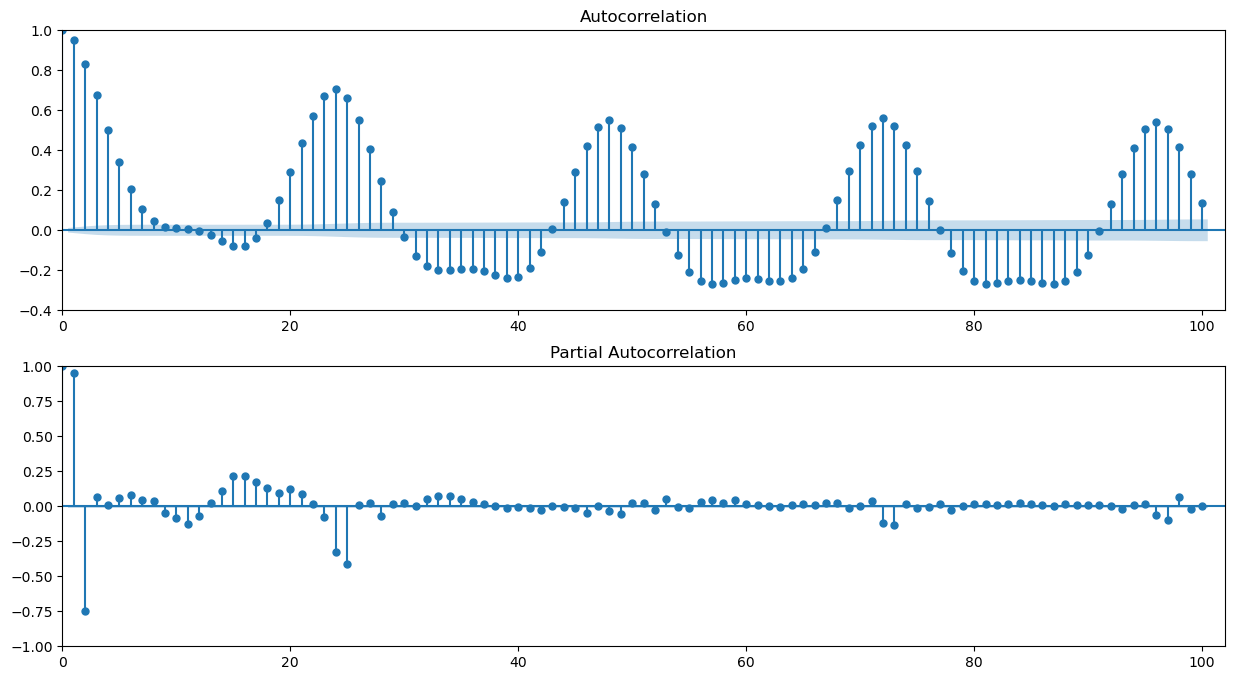

In [47]:
%%capture --no-display
#plot ACF and PACF
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(y_train, lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_train, lags=100, ax=ax[1])
ax[0].set_xlim(0, 102)
ax[0].set_ylim(-0.4,1)
ax[1].set_xlim(0, 102)
plt.show()

Next I will apply first and 24-hour seasonal differences to see how they affect the stationarity of the data:

In [55]:
ytrain_seas = y_train.diff(24)
ytrain_diff = y_train.diff()
ytrain_both = ytrain_seas.diff()
ytrain_both.tail()

time
2018-05-26 14:00:00+00:00   -480.0
2018-05-26 15:00:00+00:00   -111.0
2018-05-26 16:00:00+00:00    448.0
2018-05-26 17:00:00+00:00    418.0
2018-05-26 18:00:00+00:00    346.0
Name: total load actual, dtype: float64

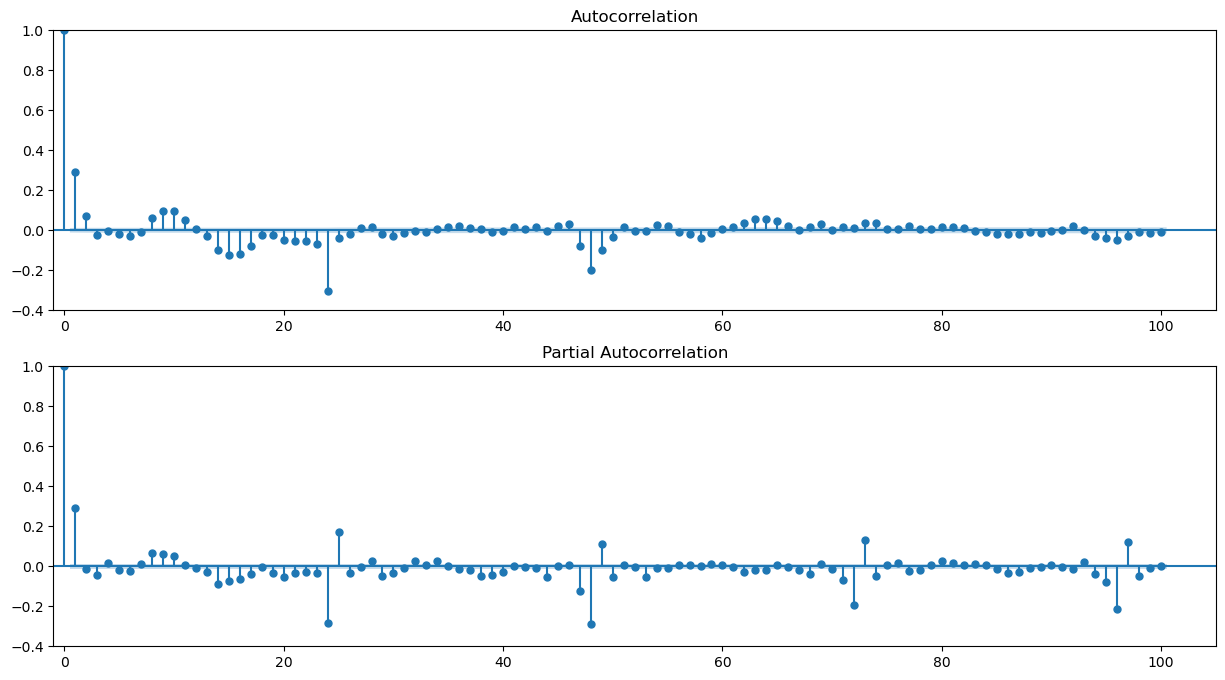

In [52]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(ytrain_both[25:], lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ytrain_both[25:], lags=100, ax=ax[1])
ax[0].set_xlim(-1, 105)
ax[0].set_ylim(-0.4,1)
ax[1].set_xlim(-1, 105)
ax[1].set_ylim(-0.4,1)
plt.show()

After differencing and seasonal differencing, the ACF and PACF plots still do not give much indication of which terms would be good for the AR and MA terms of the model.
So given the above information, a first pass at SARIMA parameters might be: (1,0,1)x(1,0,1,24) since d=0 for no trend.

In [33]:
#%conda install -c conda-forge pmdarima
#%conda install -c conda-forge statsforecast
#import pmdarima as pm
#from sktime.forecasting.arima import AutoARIMA #https://alkaline-ml.com/pmdarima/tips_and_tricks.html
#https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

''' # It seems my computer cannot handle processing AutoARIMA for a dataset of this size. 
#Instead I try a few combinations of different orders individually below
stepwise_fit = pm.auto_arima(ytrain_both, X=X_train_ff,
                             start_p=0, d=0, start_q=0,                              
                             max_p=3, max_d=0, max_q=3,                       
                             start_P=0, D=0, start_Q=0,                             
                             max_P=3, max_D=0, max_Q=3,
                             m=24, seasonal=True,
                             information_criterion='aic',
                             stepwise=True,
                             error_action='ignore',
                             trace=True)
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
stepwise_fit = StatsForecastAutoARIMA(start_p=0, d=0, start_q=0,
                                     max_p=2, max_q=2,
                                     start_P=0, D=0, start_Q=0,
                                     max_P=3, max_D=0, max_Q=3,
                                     sp=24, seasonal=True,
                                     stationary=True,
                                     information_criterion='aic',
                                     stepwise=True, trend=False)
#stepwise_fit.fit(ytrain_both)
#print(stepwise_fit.get_test_params())

'''                                     

Since my computer does not seem to be able to handle the processing required for AutoARIMA, I try a few (pdq) combinations individually below.

In [53]:
%%capture --no-display

sar_mod = sm.tsa.statespace.SARIMAX(y_train, order=(1,0,1), seasonal_order=(1,0,1,24), freq='H') #result AIC=474868
#sar_mod = sm.tsa.statespace.SARIMAX(ytrain_both, order=(0,0,1), seasonal_order=(0,0,1,24), freq='H') #res AIC=476327
#sar_mod = sm.tsa.statespace.SARIMAX(ytrain_both, order=(2,0,1), seasonal_order=(1,0,1,24), freq='H') # 474833
#sar_mod = sm.tsa.statespace.SARIMAX(ytrain_both, order=(3,0,1), seasonal_order=(1,0,1,24), freq='H') #474737
#sar_mod = sm.tsa.statespace.SARIMAX(ytrain_both, order=(7,0,1), seasonal_order=(1,0,1,24), freq='H') #474481.147
#sar_mod = sm.tsa.statespace.SARIMAX(y_train, order=(1,0,1), seasonal_order=(1,0,1,24), freq='H') #475989
#sar_mod = sm.tsa.statespace.SARIMAX(y_train, order=(3,0,1), seasonal_order=(1,0,1,24), freq='H') #475842
#sar_mod = sm.tsa.statespace.SARIMAX(y_train, order=(7,0,1), seasonal_order=(1,0,1,24), freq='H') #475412.641
#sar_modx = sm.tsa.statespace.SARIMAX(y_train, order=(7,0,1), seasonal_order=(1,0,1,24), freq='H', exog=X_train_ff) #475421
#sar_mod = sm.tsa.statespace.SARIMAX(ytrain_both, order=(7,0,1), seasonal_order=(1,0,1,24), freq='H', exog=X_train_ff) #474552

In [54]:
#sar_results = sar_mod.fit(method = 'powell')
#sar_results.summary()
sar_res = sar_mod.fit(method = 'powell')
sar_res.summary()

Optimization terminated successfully.
         Current function value: 7.985155
         Iterations: 4
         Function evaluations: 233


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  total load actual   No. Observations:                29804
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -237989.556
Date:                            Thu, 08 Dec 2022   AIC                         475989.112
Time:                                    14:03:36   BIC                         476030.623
Sample:                                12-31-2014   HQIC                        476002.435
                                     - 05-26-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9532      0.002    545.966      0.000       0.950       0.957
ma.L1          0.3608      0.002    209.645      0.000       0.357       0.364
ar.S.L24       0.9982      0.000   4183.919      0.000       0.998       0.999
ma.S.L24      -0.8933      0.002   -500.875      0.000      -0.897      -0.890
sigma2      5.056e+05   1185.751    426.390      0.000    5.03e+05    5.08e+05
===================================================================================
Ljung-Box (L1) (Q):                  52.03   Jarque-Bera (JB):           3227147.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

After trying several ARIMA orders, most have very similar AIC and BIC values. So it would make sense to use the simplest order that is performing as well as the others. Below I implement the (1,0,1)x(1,0,1,24) ARIMA model without the exogenous regressors.

In [149]:
#sar_res.plot_diagnostics(figsize=(12,8))

In [127]:
#prediction on last week of training set w/o exogenous vars
y_pred_sar = sar_res.get_prediction(start=X_train_ff.index[-24*7], end=X_train_ff.index[-1])

y_pred_sar = y_pred_sar.predicted_mean
y_pred_sar = pd.Series(y_pred_sar, index=X_train_ff.iloc[-24*7:,:].index)
error_metrics(y_true = y_train.iloc[-24*7:], y_pred = y_pred_sar, 
              model_name = "SARIMA (1,0,1)(1,0,1,24) prediction on last week of train set")


Error metrics for model: SARIMA (1,0,1)(1,0,1,24) prediction on last week of train set
RMSE: 365.80
Variance/R^2: 0.99
MAE: 244.66
Mean Absolute Percentage Error: 0.95 %


In [49]:
#sar_modx = sm.tsa.statespace.SARIMAX(y_train, order=(1,0,1), seasonal_order=(1,0,1,24), freq='H', exog=X_train_ff)

In [75]:
#sarx_results = sar_modx.fit(method = 'powell')
#sarx_results.summary()

In [140]:
#prediction on last week of training set with exogenous
'''
y_pred_sarx = sarx_results.get_prediction(start=X_train_ff.index[-24*7], end=X_train_ff.index[-1])

y_pred_sarx = y_pred_sarx.predicted_mean
y_pred_sarx = pd.Series(y_pred_sarx, index=X_train_ff.iloc[-24*7:,:].index)
error_metrics(y_true = y_train.iloc[-24*7:], y_pred = y_pred_sarx, 
              model_name = "SARIMA (7,0,1)(1,0,1,24) prediction on last week of train set with exogenous regressors")
              '''

'\ny_pred_sarx = sarx_results.get_prediction(start=X_train_ff.index[-24*7], end=X_train_ff.index[-1])\n\ny_pred_sarx = y_pred_sarx.predicted_mean\ny_pred_sarx = pd.Series(y_pred_sarx, index=X_train_ff.iloc[-24*7:,:].index)\nerror_metrics(y_true = y_train.iloc[-24*7:], y_pred = y_pred_sarx, \n              model_name = "SARIMA (7,0,1)(1,0,1,24) prediction on last week of train set with exogenous regressors")\n              '

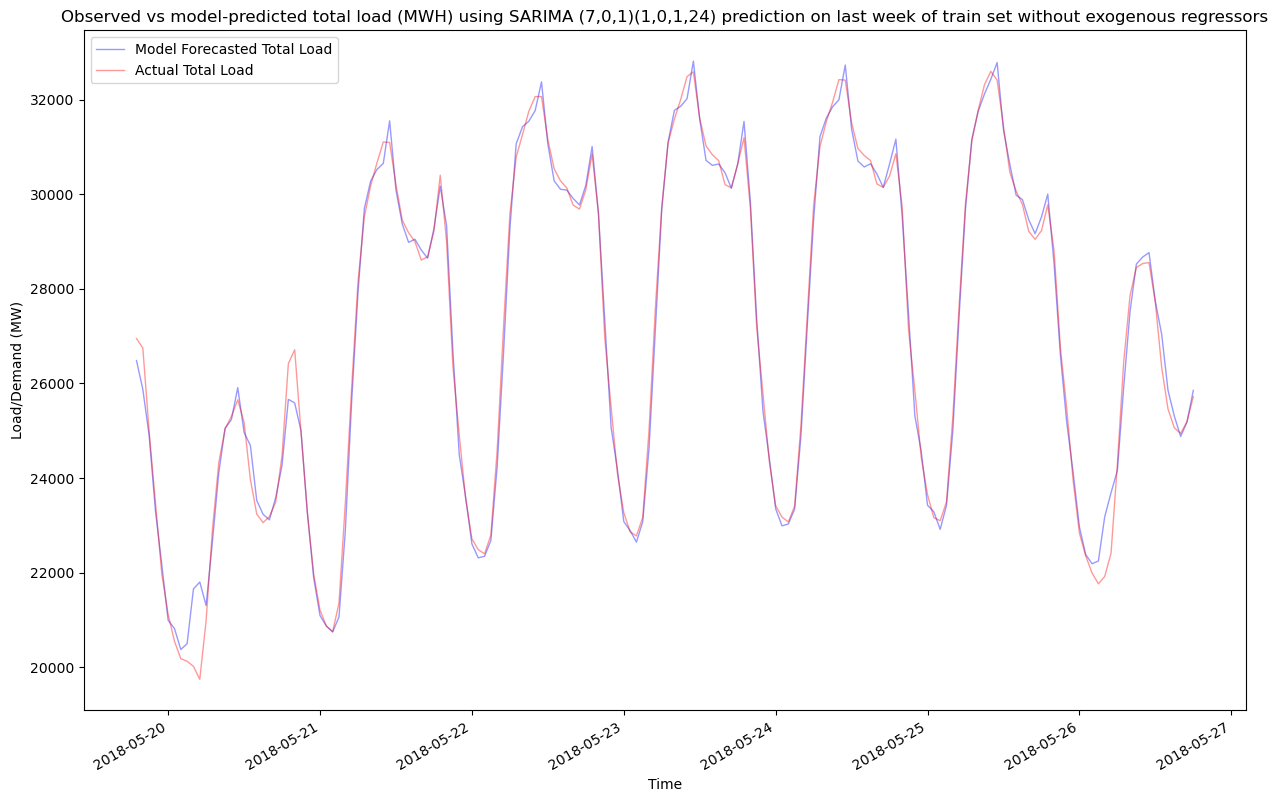

In [33]:
#plot_ts_pred_true(y_pred = y_pred_sar, y_true = y_train.iloc[-24*7:], 
 #                 model_name = "SARIMA (7,0,1)(1,0,1,24) prediction on last week of train set without exogenous regressors")

In [128]:
#prediction on first week of test set without exogenous regressors
y_pred2 = sar_res.get_forecast(steps=24*7)
#y_pred_ci = y_pred.conf_int()
y_pred2 = y_pred2.predicted_mean
y_pred2 = pd.Series(y_pred2, index=X_test_ff.iloc[:24*7,:].index)
error_metrics(y_true = y_test.iloc[:24*7], y_pred = y_pred2, 
              model_name = "SARIMA (1,0,1)(1,0,1,24) prediction on first week of test set")


Error metrics for model: SARIMA (1,0,1)(1,0,1,24) prediction on first week of test set
RMSE: 3433.54
Variance/R^2: 0.45
MAE: 2461.13
Mean Absolute Percentage Error: 8.41 %


In [38]:
#prediction on first week of test set with exogenous
'''
y_pred3 = sarx_results.get_forecast(steps=24*7, exog=X_test_ff.iloc[:24*7,:])
#y_pred_ci = y_pred.conf_int()
y_pred3 = y_pred3.predicted_mean
y_pred3 = pd.Series(y_pred3, index=X_test_ff.iloc[:24*7,:].index)
error_metrics(y_true = y_test.iloc[:24*7], y_pred = y_pred3, 
              model_name = "SARIMA (1,0,1)(1,0,1,24) prediction on first week of test set with exogenous regressors")
              '''


Error metrics for model: SARIMA (1,0,1)(1,0,1,24) prediction on first week of test set with exogenous regressors
RMSE: 3390.94
Variance/R^2: 0.46
MAE: 2410.24
Mean Absolute Percentage Error: 8.25 %


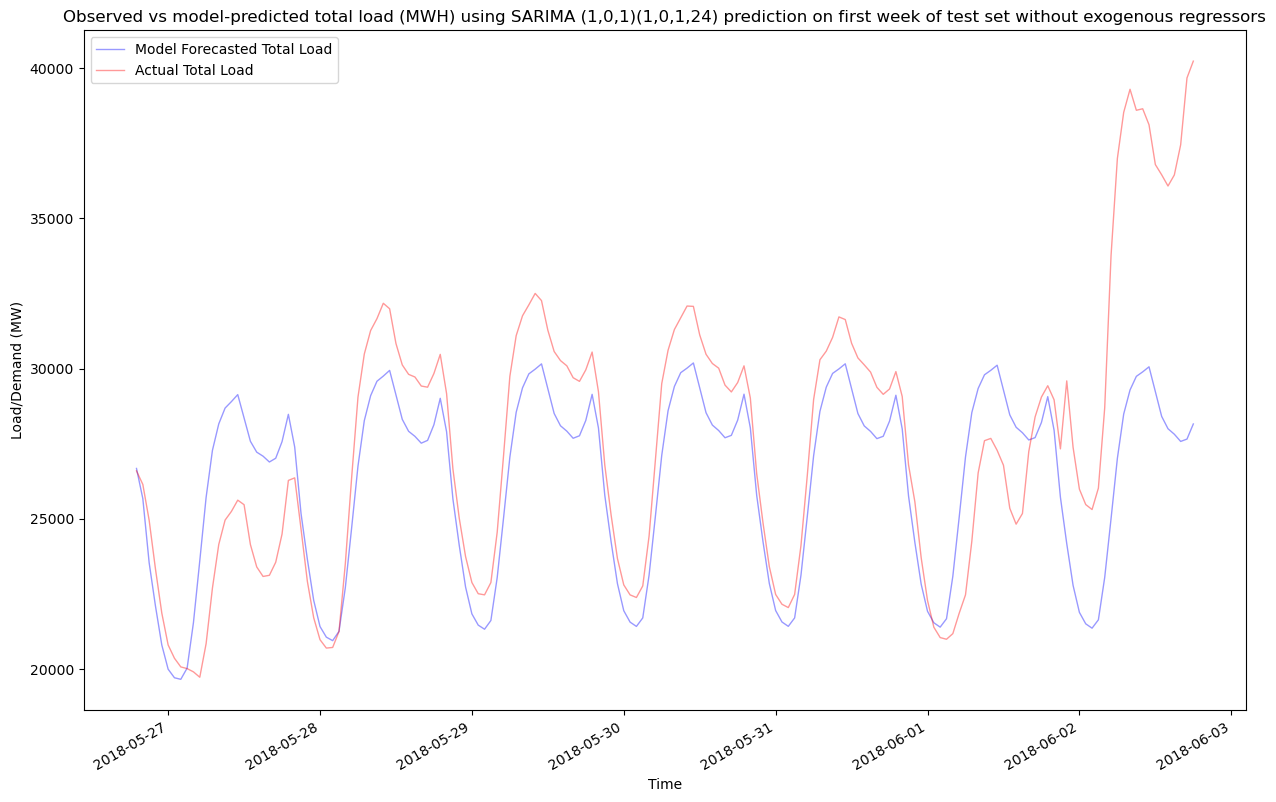

In [39]:
plot_ts_pred_true(y_pred = y_pred2, y_true = y_test.iloc[:24*7], 
                  model_name = "SARIMA (1,0,1)(1,0,1,24) prediction on first week of test set without exogenous regressors")

So the SARIMA(X) model performs somewhat poorly even just one week into the test set (1 week ahead of the end of the training set) both with and without the exogenous regressors, and slightly better without than with them. It catches the correct patterns but pretty consistently underpredicts. And as soon as the second seasonality kicks in at the end of the week (the model is handling only the daily seasonality), the accuracy drops significantly.

NOTE: after seeing that Prophet misses the mark badly on 2018-06-02 also, I did some digging and discovered that Pedro Sánchez was sworn in as Spain’s new prime minister that day, and so likely many more people than normal were indoors watching the swearing in on TV. See the discussion ater the Prophet plots for further insights.

Given this situation, let's see what the error is on just the first 6 days of the test set:

In [129]:
#prediction on first 6 days of test set without exogenous regressors
y_pred2 = sar_res.get_forecast(steps=24*6)
#y_pred_ci = y_pred.conf_int()
y_pred2 = y_pred2.predicted_mean
y_pred2 = pd.Series(y_pred2, index=X_test_ff.iloc[:24*6,:].index)
error_metrics(y_true = y_test.iloc[:24*6], y_pred = y_pred2, 
              model_name = "SARIMA on first 6 days of test set")


Error metrics for model: SARIMA on first 6 days of test set
RMSE: 2006.04
Variance/R^2: 0.71
MAE: 1719.63
Mean Absolute Percentage Error: 6.51 %


That's quite a bit better without the one anomalous day and probably more in line with what we could expect from a short to medium term forecast with SARIMAX on average with this dataset.

## FB Prophet

Unlike SARIMAX, Prophet handles multi-seasonality well so I do not need to pass in the Fourier terms separately. The exogenous variables would return to just the weather variables. Prophet needs the time data in a specific format (not as index). And the target variable column needs to be named 'y'. You can add seasonalities, regressors, and even holidays in a given country.

In [18]:
#%conda install -c conda-forge prophet
from prophet import Prophet

#for now, let's try with just the basic weather vars as our regressors
#prophet_min = combined_avg.iloc[:,16:].drop(['price day ahead', 'price actual','total load forecast'], axis=1)
#features_min = df_features.copy()
prophet_min = features_min.copy()
prophet_min.head(3)

,total load actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
time,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0


In [19]:
# function to transform data to format needed for Prophet
def prophetize(df):
    df_prophetized = df.reset_index().rename(columns={'total load actual':'y', 'time':'ds'})
    df_prophetized['ds'] = df_prophetized['ds'].dt.tz_localize(None)
    return df_prophetized

In [20]:
# 'prophetize' the data:
prophet_df = prophetize(prophet_min)
prophet_df.head(3)

,ds,y,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
0,2014-12-31 23:00:00,25385.0,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
1,2015-01-01 00:00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0
2,2015-01-01 01:00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0


In [21]:
#perform train-test split and Scaling
X_trainP, X_testP, y_trainP, y_testP = ts_train_test(data = prophet_df, target_col_name = 'y', stdzd=True, 
                                                 cols_to_scale=['temp','pressure','humidity',
                                                                'wind_speed','rain_1h','snow_3h','clouds_all'])

In [22]:
# create train and test sets for Prophet
trainP = pd.merge(X_trainP, y_trainP, left_index=True, right_index=True)
testP = pd.merge(X_testP, y_testP, left_index=True, right_index=True)
trainP.head()

,ds,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,y
0,2014-12-31 23:00:00,-2.327401,0.038628,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,25385.0
1,2015-01-01 00:00:00,-2.324453,0.015395,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,24382.0
2,2015-01-01 01:00:00,-2.381861,0.085093,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,22734.0
3,2015-01-01 02:00:00,-2.383203,0.061861,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,21286.0
4,2015-01-01 03:00:00,-2.375370,0.061861,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,20264.0


In [23]:
#create instance of Prophet model
proph_mod = Prophet(interval_width = 0.95, 
                yearly_seasonality='auto',
                weekly_seasonality='auto',
                daily_seasonality='auto',
                seasonality_mode='additive')

In [24]:
#add the regressor variables:
proph_mod.add_regressor('temp', standardize=False)
proph_mod.add_regressor('pressure', standardize=False)
proph_mod.add_regressor('humidity', standardize=False)
proph_mod.add_regressor('wind_speed', standardize=False)
proph_mod.add_regressor('rain_1h', standardize=False)
proph_mod.add_regressor('snow_3h', standardize=False)
proph_mod.add_regressor('clouds_all', standardize=False)

In [25]:
%%capture --no-display
# fit the model
proph_mod.fit(trainP)

In [27]:
%%capture --no-display
#dataframe with dt values to predict on (pred on train and test set)
future_dates = proph_mod.make_future_dataframe(periods=len(testP), freq='H', include_history=True)
# add regressors 
future_dates = pd.merge(future_dates, (trainP.append(testP)).drop('y', axis=1), on = 'ds')
future_dates.tail()

,ds,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
35059,2018-12-31 18:00:00,-0.664638,1.525514,0.382262,-0.777023,-0.369491,-0.052006,-1.423223
35060,2018-12-31 19:00:00,-0.966692,1.618444,0.001593,-0.491832,-0.369491,-0.052006,-1.423223
35061,2018-12-31 20:00:00,-1.167137,1.595212,0.232713,0.078551,-0.369491,-0.052006,-1.423223
35062,2018-12-31 21:00:00,-1.324272,1.641677,0.137546,0.221147,-0.369491,-0.052006,-1.423223
35063,2018-12-31 22:00:00,-1.451979,1.641677,0.980456,0.078551,-0.369491,-0.052006,-1.423223


In [28]:
%%capture --no-display
# predict 
forecast = proph_mod.predict(future_dates)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
35059,2018-12-31 18:00:00,31622.934868,25891.702613,37251.659495
35060,2018-12-31 19:00:00,31868.392817,26450.022863,37794.654528
35061,2018-12-31 20:00:00,30960.223550,25088.382191,36855.418787
35062,2018-12-31 21:00:00,29167.680926,23313.656528,35174.898519
35063,2018-12-31 22:00:00,27033.572762,21329.368280,32960.394200


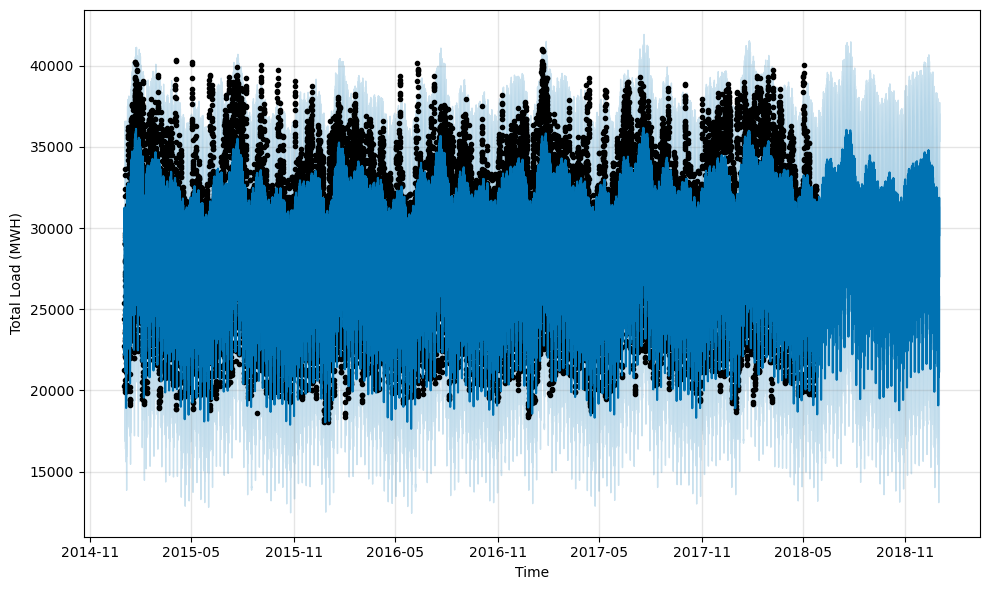

In [39]:
#ploit using Prophet's built in plotting feature
_ = proph_mod.plot(forecast, uncertainty = True, xlabel = 'Time', ylabel = 'Total Load (MWH)')

The above plot was created with Prophet's built-in plot method. The black are the true values, dark blue the prediction, and light blue are the 95% confidence bands. It appears that the model does a reasonably good job overall, and predicts the lows quite well, while coming in a bit low on most of the peak loads.

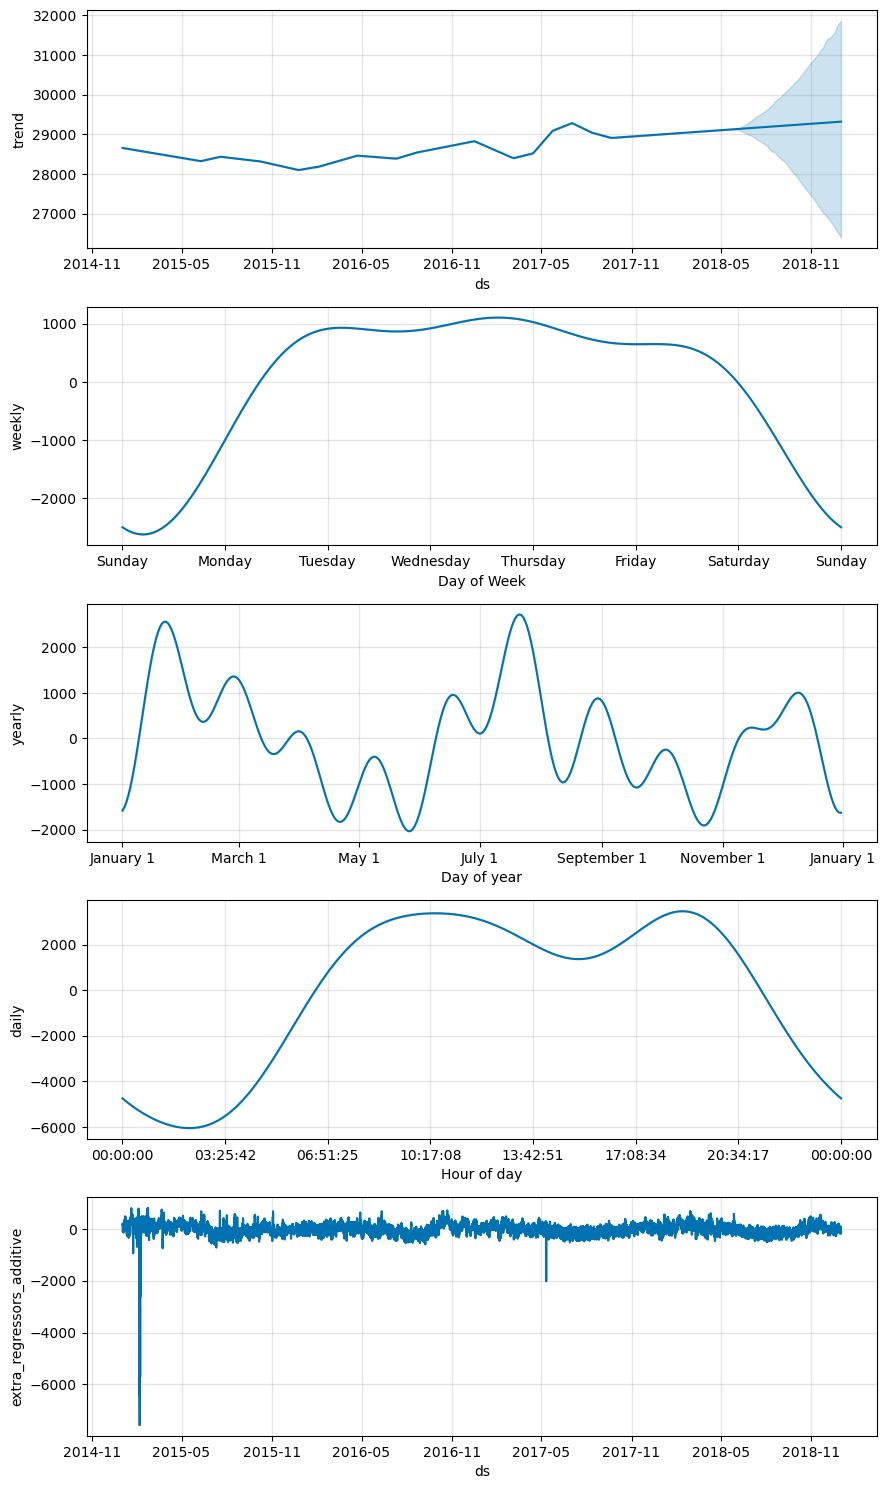

In [29]:
%%capture --no-display
#plot the components of the results
_ = proph_mod.plot_components(forecast)

In [130]:
#calculate error metrics on train data
error_metrics(y_true = trainP['y'], y_pred = forecast.iloc[:len(trainP)]['yhat'], 
              model_name = "FB Prophet Using Auto-Seasonality and Weather Regressors (train)")


Error metrics for model: FB Prophet Using Auto-Seasonality and Weather Regressors (train)
RMSE: 2666.49
Variance/R^2: 0.66
MAE: 2003.11
Mean Absolute Percentage Error: 7.15 %


In [131]:
#error metrics on test data
error_metrics(y_true = testP['y'], y_pred = forecast.iloc[-len(testP):]['yhat'], 
              model_name = "FB Prophet Using Auto-Seasonality and Weather Regressors (test)")


Error metrics for model: FB Prophet Using Auto-Seasonality and Weather Regressors (test)
RMSE: 2750.33
Variance/R^2: 0.64
MAE: 2069.42
Mean Absolute Percentage Error: 7.23 %


So far, FB Prophet performs the best on the long range, multi-month forecast of all the models tested.

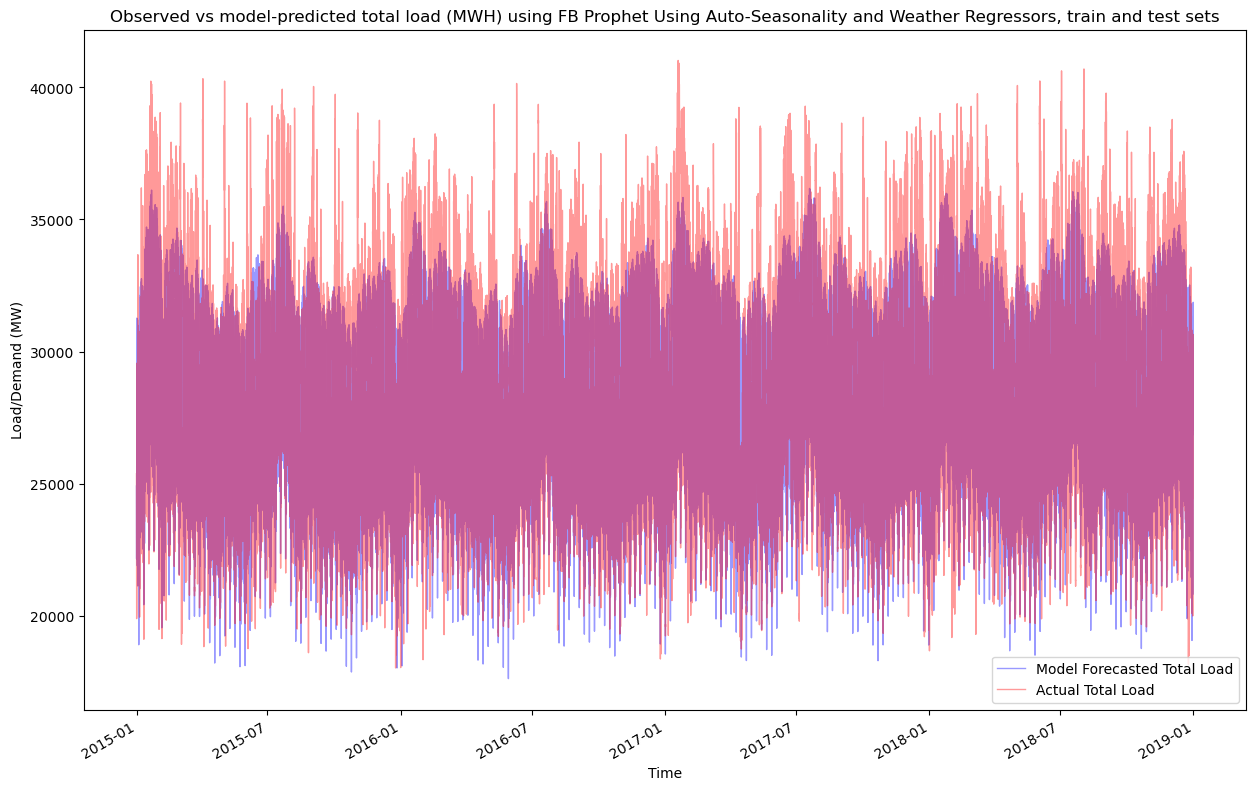

In [29]:
%%capture --no-display
#plot the entirety of the Prophet predicted and true loads
plot_ts_pred_true(y_pred = forecast.set_index('ds')['yhat'], y_true = trainP.append(testP).set_index('ds')['y'], 
                  model_name = "FB Prophet Using Auto-Seasonality and Weather Regressors, train and test sets")

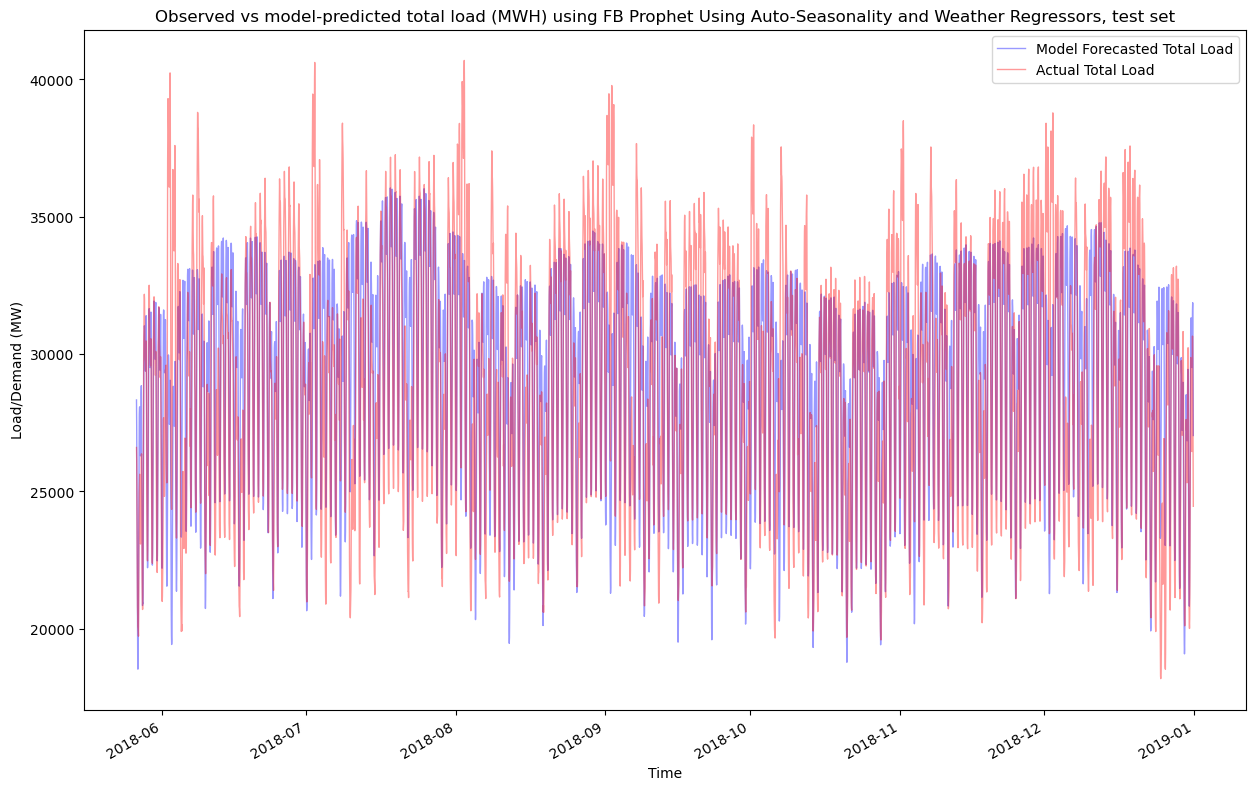

In [38]:
%%capture --no-display
#plot the test set only
plot_ts_pred_true(y_pred = forecast.set_index('ds')['yhat'].iloc[-len(testP):], 
                  y_true = trainP.append(testP).set_index('ds')['y'].iloc[-len(testP):], 
                  model_name = "FB Prophet Using Auto-Seasonality and Weather Regressors, test set")

In [41]:
%%capture --no-display
#let's see how Prophet does on just the first week of the test set:
#dataframe with dt values to predict on (pred on train and test set)
future_dates_week = proph_mod.make_future_dataframe(periods=24*7, freq='H', include_history=True)
# add regressors 
future_dates_week = pd.merge(future_dates_week, (trainP.append((testP).iloc[:24*7]).drop('y', axis=1)), on = 'ds')
future_dates_week.tail()

,ds,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
29967,2018-06-02 14:00:00,0.983060,0.108326,-1.018056,0.221147,-0.369491,-0.052006,0.372000
29968,2018-06-02 15:00:00,0.926425,0.015395,-0.990865,-0.064045,-0.075480,-0.052006,0.372000
29969,2018-06-02 16:00:00,0.911710,-0.007837,-0.786936,0.221147,-0.369491,-0.052006,0.198269
29970,2018-06-02 17:00:00,0.719040,-0.031070,-0.107170,1.789700,0.512542,-0.052006,0.777373
29971,2018-06-02 18:00:00,0.677396,-0.077535,-0.120765,1.076721,-0.369491,-0.052006,-0.091283


In [42]:
%%capture --no-display
#predict on the first week of test set
forecast_week = proph_mod.predict(future_dates_week)
forecast_week[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
29967,2018-06-02 14:00:00,27924.368441,22770.451632,33355.799056
29968,2018-06-02 15:00:00,27441.848840,22538.024697,32736.909076
29969,2018-06-02 16:00:00,27471.805068,22351.511334,32891.840155
29970,2018-06-02 17:00:00,28061.130721,22822.419122,33230.906347
29971,2018-06-02 18:00:00,28821.293834,23782.960637,34383.070460


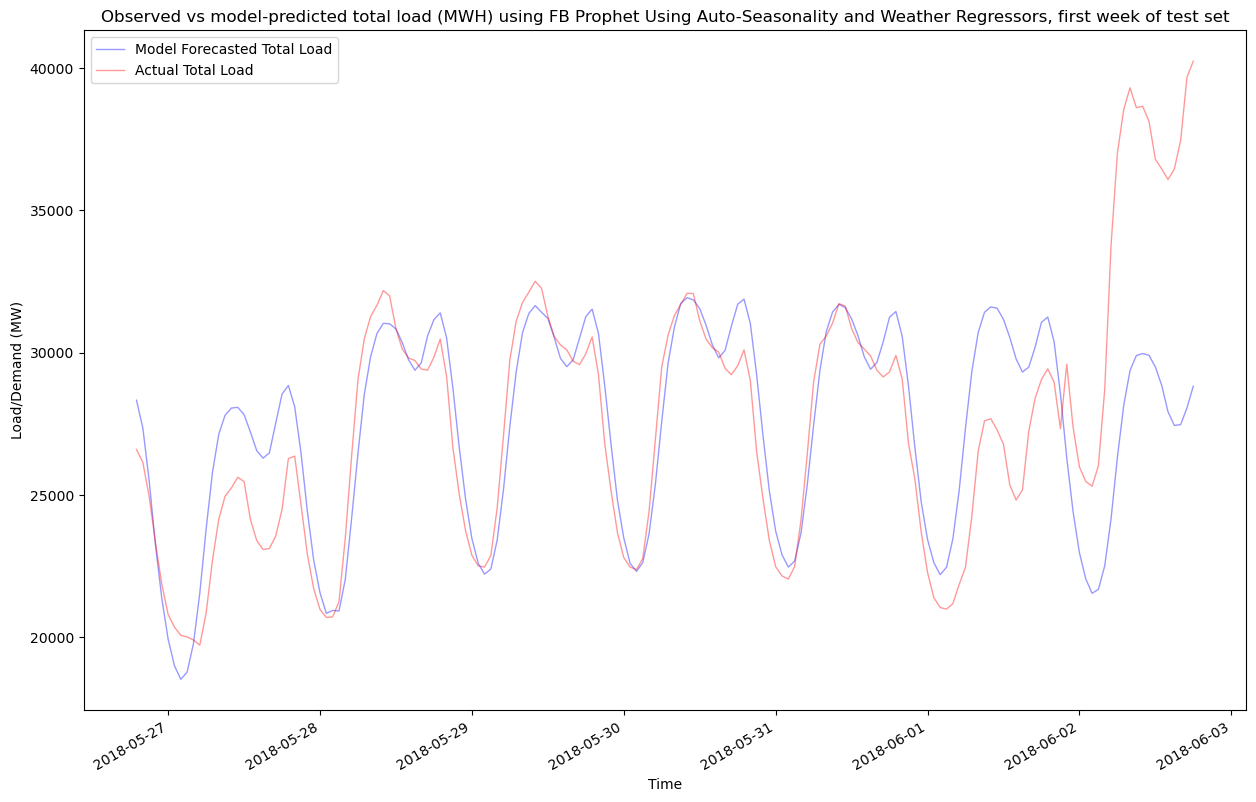

In [47]:
%%capture --no-display
#plot first week of test set
plot_ts_pred_true(y_pred = forecast_week.set_index('ds')['yhat'].iloc[-24*7:], 
                  y_true = trainP.append((testP).iloc[:24*7]).set_index('ds')['y'].iloc[-24*7:], 
                  model_name = "FB Prophet Using Auto-Seasonality and Weather Regressors, first week of test set")

Here we again see the same as with SARIMAX, the model is underpredicting on the 7th day of the first week of the test set, which is a Saturday. Typically the weekends have a lower demand than weekdays, so I did some digging and the only remarkable event I could find was that Pedro Sánchez was sworn in as Spain’s new prime minister on Saturday June 2, 2018. So maybe the whole country was at home or at the bar, indoors at least, watching the swearing in on television and power demand was much higher than normal for a Saturday. This goes to show how a single event can throw off a model's prediction. It would be difficult for almost any model to handle something like this without a human manually telling the model to treat this day differently in some way. It looks like demand dips lower than normal on Friday too, maybe many people left work early and so demand dipped.

In [132]:
#let's see the error metrics on just the first 6 days of the test set without the anomalous day:
error_metrics(y_true = testP['y'].iloc[:24*6], y_pred = forecast_week.iloc[-24*6:]['yhat'], 
              model_name = "FB Prophet, 6-day forecast (test)")


Error metrics for model: FB Prophet, 6-day forecast (test)
RMSE: 2386.61
Variance/R^2: 0.58
MAE: 1655.44
Mean Absolute Percentage Error: 5.05 %


So we see that Prophet did better on a short-medium term forecast than it did on the long term forecast, and it performed similarly on the six day forecast compared to SARIMAX (SARIMAX had lower RMSE and R2 but higher MAPE).

Let's also see how well the Prophet model predicted compared to the TSO total load prediction (one of the columns of the original dataset; it is a 24-hr ahead forecast).

In [47]:
#RMSE of actual load vs TSO forecast load
TSO_pred = combined_avg["total load forecast"].iloc[-len(testP):]
RMSE = np.sqrt(mean_squared_error(testP['y'], TSO_pred))
MAPE = (np.mean(np.abs((testP['y'] - TSO_pred) / testP['y'])) * 100)
print("RMSE= {0:.2f}".format(RMSE))

RMSE= 340.87


C:\Users\ehard\AppData\Local\Temp\ipykernel_22296\3927823573.py:4: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  MAPE = (np.mean(np.abs((testP['y'] - TSO_pred) / testP['y'])) * 100)


So on average for the whole test set, the RMSE between the TSO forecast and actual load was only about 341 MWH. But keep in mind that this is for a 24-hour ahead forecast, likely with the training set continuously updated to include the most recent data. 

## XGBoost

One other model to try would be Extreme Gradient Boosting (or XGBoost) which is very good at finding patterns in data and often provides better results than other ML algorithms. XGBoost can do a decent job with time series forecasting where there is seasonality but not much trend, as it cannot extrapolate. Since this dataset essentially has no trend, it may perform well.

In [62]:
%%capture --no-display
from xgboost import XGBRegressor

In [63]:
#set up a parameter grid for hyperparameter Random CV search:

n_est = [int(n) for n in np.logspace(start=1, stop=2.5, num=10)]
max_depth = [0,3,6,9]
learn_rate = [0.1,0.2,0.3,0.4,0.5]

xgb_param_grid = {
        'n_estimators': n_est,
        'max_depth': max_depth,
        'learning_rate':learn_rate
}
xgb_param_grid

{'n_estimators': [10, 14, 21, 31, 46, 68, 100, 146, 215, 316],
 'max_depth': [0, 3, 6, 9],
 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}

In [64]:
%%capture --no-display
#create XGB model instance
xgb_model = XGBRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
xgb_cv = RandomizedSearchCV(xgb_model, param_distributions=xgb_param_grid, scoring='neg_root_mean_squared_error', cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
xgb_cv.fit(X_train, y_train)

xgb_cv.best_params_

{'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.4}

In [65]:
# calculate the RMSE of the model on the train set using the tuned hyperparameters
# best_params = {'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.4}
best_RMSE = xgb_cv.best_score_
print(-best_RMSE)

2916.6208202064217


In [92]:
# predict on the test set
xgb_pred = xgb_cv.predict(X_test)

In [133]:
#calculate error metrics on train data
error_metrics(y_true = y_train, y_pred = xgb_cv.predict(X_train), 
              model_name = "XGBoost with weather data and engineered time-based features (train)")


Error metrics for model: XGBoost with weather data and engineered time-based features (train)
RMSE: 2535.99
Variance/R^2: 0.69
MAE: 1870.65
Mean Absolute Percentage Error: 6.69 %


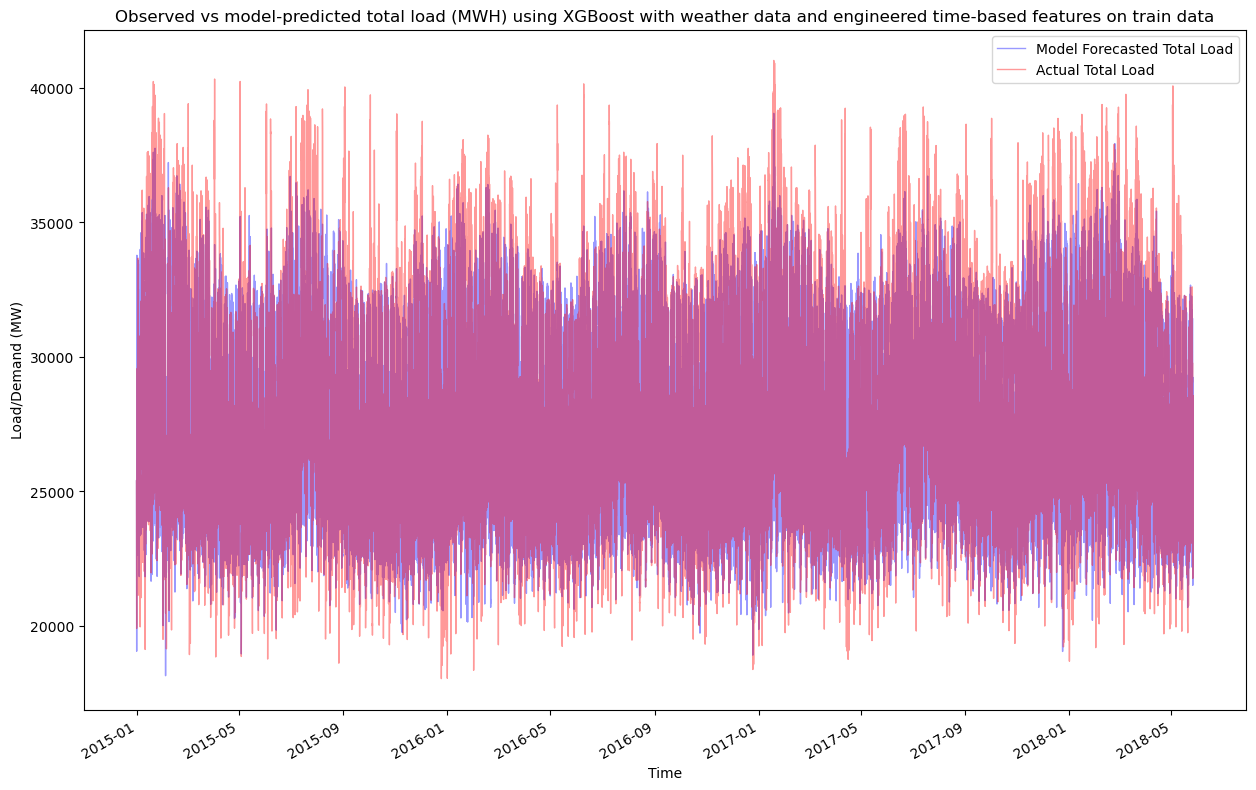

In [35]:
# plot the y_pred and y_true for train set
plot_ts_pred_true(y_pred = xgb_cv.predict(X_train), y_true = y_train, 
                  model_name = "XGBoost with weather data and engineered time-based features on train data")

In [134]:
#calculate error metrics on test data
error_metrics(y_true = y_test, y_pred = xgb_pred, 
              model_name = "XGBoost with weather data and engineered time-based features (test)")


Error metrics for model: XGBoost with weather data and engineered time-based features (test)
RMSE: 2820.17
Variance/R^2: 0.62
MAE: 2076.55
Mean Absolute Percentage Error: 7.11 %


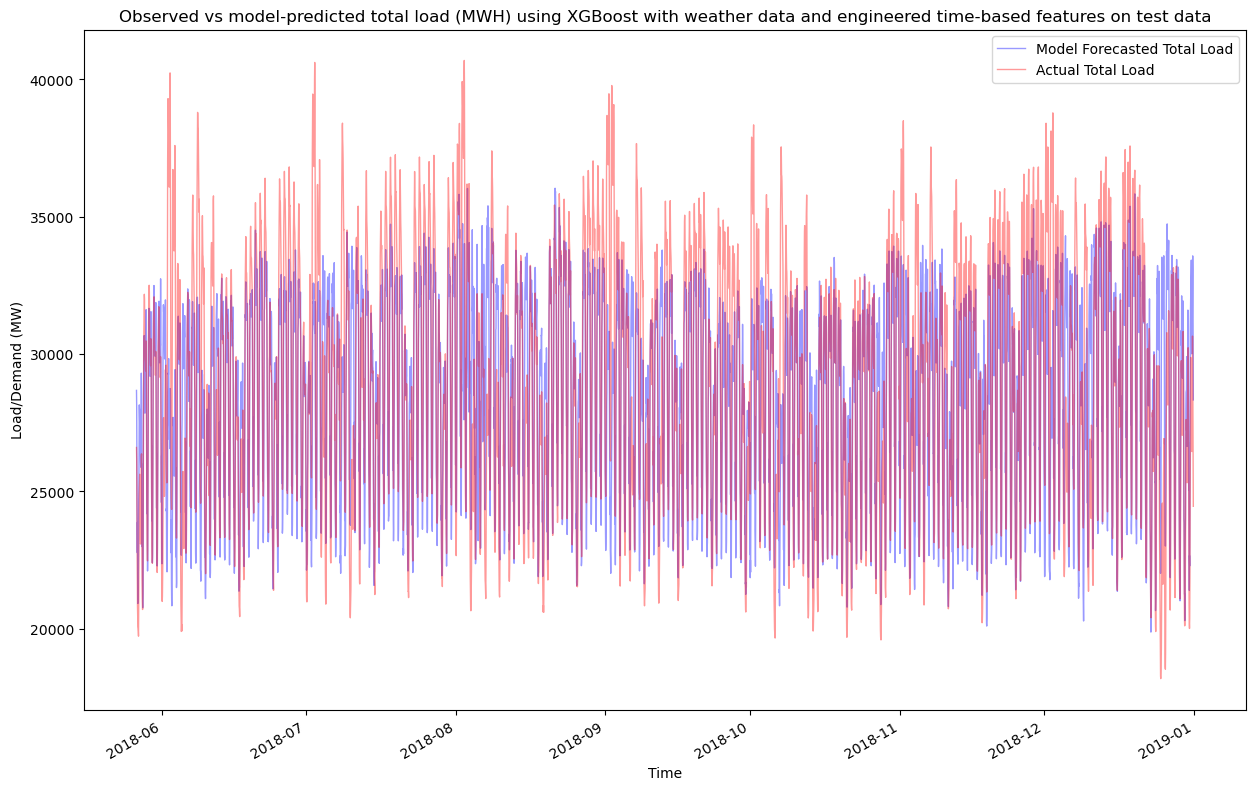

In [36]:
# plot the y_pred and y_true for test set
plot_ts_pred_true(y_pred = xgb_pred, y_true = y_test, 
                  model_name = "XGBoost with weather data and engineered time-based features on test data")

# Conclusions
Multiple models and variations on them were used to forecast the total energy demand in Spain (in MWH) using hourly load and weather data. The demand is highly dependent on temperature as well as time of day and day of week. As a time series, it exhibits daily, weely, and yearly seasonalities, but does not display much of a trend. Below is a compilation of the various models and their error metrics on training and test data.

In [135]:
#after running the error metric function on each model, the error_dict is populated w/ metrics for each
error_df = pd.DataFrame.from_dict(error_dict)

# create table and sort based on lowest RMSE
sorted_errors = error_df.pivot_table(index='Model Name', aggfunc='min').sort_values('RMSE', ascending=True)
sorted_errors

,MAE,MAPE,R2,RMSE
Model Name,,,,
"SARIMA (1,0,1)(1,0,1,24) prediction on last week of train set",244.655648,0.953523,0.989714,365.799972
SARIMA on first 6 days of test set,1719.630997,6.509132,0.706752,2006.044830
"FB Prophet, 6-day forecast (test)",1655.435911,5.046283,0.584935,2386.609390
XGBoost with weather data and engineered time-based features (train),1870.645202,6.687395,0.692153,2535.991551
FB Prophet Using Auto-Seasonality and Weather Regressors (train),2003.110948,7.150217,0.659654,2666.492356
FB Prophet Using Auto-Seasonality and Weather Regressors (test),2069.418656,7.225991,0.641096,2750.330062
XGBoost with weather data and engineered time-based features (test),2076.545817,7.106882,0.622636,2820.173524
simple linear regression (test),2174.657700,7.547725,0.358136,2850.020268
simple linear regression (train),2202.735203,7.639622,0.355824,2860.942499


### Take Home: 
Based on RMSE, Prophet barely edges out XGBoost in terms of performance on the 7-month forecast of total energy demand, based on 41 months of training data. Prophet performs similarly to SARIMAX days into the forecast window, and with considerably lower training time. But since the SARIMA does so well on the training data, it may be useful on very short forecast windows, one to several hours into the future. Both have a place, as accurate long term forecasts are important for general planning and overall energy generation mix strategy, while hour-ahead (to several hours ahead) forecasts are critical for firing on fast-to-ramp-up systems for meeting peak demands.

### Further Investigation
Future efforts with this dataset could compare Prophet and/or XGBoost to the Spanish system operator's prediction of the total load. It would also be interesting to predict the contribution of wind generated energy given the wind speed and total load.